# Infrared Camera Exposure Calculations

This notebook walks through the radiometric signal chain from an extended IR source to electron generation at a silicon sensor.

## Problem Setup
- **Light source**: Extended Lambertian IR source at 850nm
- **Irradiance at lens**: 1 W/cm² + 
- **Sensor**: BSI silicon sensor with 2.6 µm pixel pitch, 35% QE at 850nm
- **Two lens configurations** to compare

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# For nicer output formatting
from IPython.display import display, Markdown

def print_result(name, value, unit):
    """Helper to print results nicely"""
    if value < 0.01 or value > 10000:
        print(f"{name}: {value:.3e} {unit}")
    else:
        print(f"{name}: {value:.4f} {unit}")

## 1. Physical Constants

In [8]:
# Fundamental constants
h = 6.626e-34       # Planck's constant [J·s]
c = 3.0e8           # Speed of light [m/s]
wavelength = 850e-9 # Wavelength [m]

# Photon energy at 850nm
E_photon = (h * c) / wavelength

print("=== Physical Constants ===")
print(f"Wavelength: {wavelength * 1e9:.0f} nm")
print_result("Photon energy", E_photon, "J")
print_result("Photon energy", E_photon / 1.602e-19, "eV")

=== Physical Constants ===
Wavelength: 850 nm
Photon energy: 2.339e-19 J
Photon energy: 1.4598 eV


## 2. Sensor Parameters

In [9]:
# Sensor specifications
pixel_pitch = 2.6e-6          # Pixel size [m]
pixel_area = pixel_pitch ** 2  # Pixel area [m²]
quantum_efficiency = 0.35      # QE at 850nm [dimensionless]
full_well_capacity = 6000      # Typical for 2.6µm BSI pixel [electrons]

print("=== Sensor Parameters ===")
print(f"Pixel pitch: {pixel_pitch * 1e6:.1f} µm")
print_result("Pixel area", pixel_area * 1e12, "µm²")
print_result("Pixel area", pixel_area, "m²")
print(f"Quantum efficiency: {quantum_efficiency * 100:.0f}%")
print(f"Full-well capacity: {full_well_capacity} electrons")

=== Sensor Parameters ===
Pixel pitch: 2.6 µm
Pixel area: 6.7600 µm²
Pixel area: 6.760e-12 m²
Quantum efficiency: 35%
Full-well capacity: 6000 electrons


## 3. Lens Parameters

We'll compare two lenses:
- **Lens A**: Standard wide-angle (65° FOV, f/1.8)
- **Lens B**: Fisheye (175° FOV, f/2.35)

In [10]:
# Lens specifications stored in dictionaries
lens_A = {
    'name': 'Lens A (Standard)',
    'fov_deg': 65,           # Full field of view [degrees]
    'focal_length_mm': 3.6,  # Focal length [mm]
    'f_number': 1.8          # F-number [dimensionless]
}

lens_B = {
    'name': 'Lens B (Fisheye)',
    'fov_deg': 175,
    'focal_length_mm': 1.2,
    'f_number': 2.35
}

# Calculate derived quantities for each lens
def calculate_lens_params(lens):
    """Calculate derived optical parameters"""
    lens['half_fov_deg'] = lens['fov_deg'] / 2
    lens['half_fov_rad'] = np.radians(lens['half_fov_deg'])
    lens['entrance_pupil_mm'] = lens['focal_length_mm'] / lens['f_number']
    lens['sin_squared_alpha'] = np.sin(lens['half_fov_rad']) ** 2
    return lens

lens_A = calculate_lens_params(lens_A)
lens_B = calculate_lens_params(lens_B)

# Display lens parameters
for lens in [lens_A, lens_B]:
    print(f"\n=== {lens['name']} ===")
    print(f"Field of View: {lens['fov_deg']}° (half-angle: {lens['half_fov_deg']}°)")
    print(f"Focal length: {lens['focal_length_mm']} mm")
    print(f"F-number: f/{lens['f_number']}")
    print(f"Entrance pupil diameter: {lens['entrance_pupil_mm']:.2f} mm")
    print(f"sin²(α): {lens['sin_squared_alpha']:.4f}")


=== Lens A (Standard) ===
Field of View: 65° (half-angle: 32.5°)
Focal length: 3.6 mm
F-number: f/1.8
Entrance pupil diameter: 2.00 mm
sin²(α): 0.2887

=== Lens B (Fisheye) ===
Field of View: 175° (half-angle: 87.5°)
Focal length: 1.2 mm
F-number: f/2.35
Entrance pupil diameter: 0.51 mm
sin²(α): 0.9981


## 4. Scene and Illumination

We have an extended Lambertian source producing 0.1 W/m² irradiance at the lens surface.

In [11]:
# Scene parameters
E_lens_Wcm2 = 1 # Irradiance at lens [W/cm²] 
E_lens = E_lens_Wcm2 * 10000            # Irradiance at lens [W/m²]
lens_transmission = 0.9 # Typical lens transmission [dimensionless]

print("=== Scene Parameters ===")
print(f"Irradiance at lens: {E_lens} W/m²")
print(f"Lens transmission: {lens_transmission * 100:.0f}%")

=== Scene Parameters ===
Irradiance at lens: 10000 W/m²
Lens transmission: 90%


## 5. Radiometry Calculations

### Step 5.1: From Lens Irradiance to Scene Radiance

For an extended Lambertian source filling half-angle α, the irradiance at the lens is:

$$E_{lens} = \pi \cdot L \cdot \sin^2(\alpha)$$

Solving for radiance:

$$L = \frac{E_{lens}}{\pi \cdot \sin^2(\alpha)}$$

In [12]:
def calculate_radiance(E_lens, sin_squared_alpha):
    """
    Calculate scene radiance from lens irradiance.
    
    For extended Lambertian source:
    E_lens = π * L * sin²(α)
    
    Parameters:
    -----------
    E_lens : float
        Irradiance at lens surface [W/m²]
    sin_squared_alpha : float
        sin²(half-angle of FOV)
    
    Returns:
    --------
    L : float
        Scene radiance [W/(m²·sr)]
    """
    L = E_lens / (np.pi * sin_squared_alpha)
    return L

# Calculate for both lenses
lens_A['radiance'] = calculate_radiance(E_lens, lens_A['sin_squared_alpha'])
lens_B['radiance'] = calculate_radiance(E_lens, lens_B['sin_squared_alpha'])

print("=== Scene Radiance ===")
print(f"\nNote: Same irradiance at lens, but different implied scene radiance")
print(f"because the FOV determines how much solid angle contributes.\n")

for lens in [lens_A, lens_B]:
    print(f"{lens['name']}: L = {lens['radiance']:.4f} W/(m²·sr)")

=== Scene Radiance ===

Note: Same irradiance at lens, but different implied scene radiance
because the FOV determines how much solid angle contributes.

Lens A (Standard): L = 11025.9769 W/(m²·sr)
Lens B (Fisheye): L = 3189.1667 W/(m²·sr)


### Step 5.2: From Scene Radiance to Sensor Irradiance

The camera equation for extended sources:

$$E_{sensor} = \frac{\pi \cdot L \cdot \tau}{4 \cdot N^2}$$

where:
- $L$ = scene radiance [W/(m²·sr)]
- $\tau$ = lens transmission
- $N$ = f-number

Alternatively, substituting the radiance equation:

$$E_{sensor} = \frac{E_{lens} \cdot \tau}{4 \cdot N^2 \cdot \sin^2(\alpha)}$$

In [13]:
def calculate_sensor_irradiance(radiance, transmission, f_number):
    """
    Calculate irradiance at the sensor plane.
    
    Camera equation: E_sensor = (π * L * τ) / (4 * N²)
    
    Parameters:
    -----------
    radiance : float
        Scene radiance [W/(m²·sr)]
    transmission : float
        Lens transmission factor
    f_number : float
        Lens f-number
    
    Returns:
    --------
    E_sensor : float
        Irradiance at sensor [W/m²]
    """
    E_sensor = (np.pi * radiance * transmission) / (4 * f_number**2)
    return E_sensor

# Calculate for both lenses
lens_A['E_sensor'] = calculate_sensor_irradiance(
    lens_A['radiance'], lens_transmission, lens_A['f_number'])
lens_B['E_sensor'] = calculate_sensor_irradiance(
    lens_B['radiance'], lens_transmission, lens_B['f_number'])

print("=== Sensor Irradiance ===")
for lens in [lens_A, lens_B]:
    print(f"{lens['name']}: E_sensor = {lens['E_sensor']*1000:.2f} mW/m²")

print(f"\nRatio (A/B): {lens_A['E_sensor']/lens_B['E_sensor']:.1f}x")

=== Sensor Irradiance ===
Lens A (Standard): E_sensor = 2405495.01 mW/m²
Lens B (Fisheye): E_sensor = 408200.84 mW/m²

Ratio (A/B): 5.9x


### Step 5.3: Photon Flux at Each Pixel

$$\Phi_{pixel} = \frac{E_{sensor}}{E_{photon}} \times A_{pixel}$$

Units: photons per second per pixel

In [14]:
def calculate_photon_flux(E_sensor, E_photon, A_pixel):
    """
    Calculate photon flux per pixel.
    
    Parameters:
    -----------
    E_sensor : float
        Irradiance at sensor [W/m²]
    E_photon : float
        Energy per photon [J]
    A_pixel : float
        Pixel area [m²]
    
    Returns:
    --------
    photon_flux : float
        Photons per pixel per second
    """
    photon_flux_density = E_sensor / E_photon  # photons/(m²·s)
    photon_flux = photon_flux_density * A_pixel  # photons/pixel/s
    return photon_flux

# Calculate for both lenses
lens_A['photon_flux'] = calculate_photon_flux(lens_A['E_sensor'], E_photon, pixel_area)
lens_B['photon_flux'] = calculate_photon_flux(lens_B['E_sensor'], E_photon, pixel_area)

print("=== Photon Flux per Pixel ===")
for lens in [lens_A, lens_B]:
    print(f"{lens['name']}: {lens['photon_flux']:.2e} photons/pixel/s")

=== Photon Flux per Pixel ===
Lens A (Standard): 6.95e+10 photons/pixel/s
Lens B (Fisheye): 1.18e+10 photons/pixel/s


### Step 5.4: Electron Generation Rate

$$\dot{n}_e = QE \times \Phi_{pixel}$$

Units: electrons per second per pixel

In [15]:
def calculate_electron_rate(photon_flux, qe):
    """
    Calculate electron generation rate.
    
    Parameters:
    -----------
    photon_flux : float
        Photons per pixel per second
    qe : float
        Quantum efficiency
    
    Returns:
    --------
    electron_rate : float
        Electrons per pixel per second
    """
    return photon_flux * qe

# Calculate for both lenses
lens_A['electron_rate'] = calculate_electron_rate(lens_A['photon_flux'], quantum_efficiency)
lens_B['electron_rate'] = calculate_electron_rate(lens_B['photon_flux'], quantum_efficiency)

print("=== Electron Generation Rate ===")
for lens in [lens_A, lens_B]:
    print(f"{lens['name']}: {lens['electron_rate']:.2e} electrons/pixel/s")

=== Electron Generation Rate ===
Lens A (Standard): 2.43e+10 electrons/pixel/s
Lens B (Fisheye): 4.13e+09 electrons/pixel/s


### Step 5.5: Required Integration Time

$$t_{int} = \frac{n_{target}}{\dot{n}_e}$$

We'll calculate for both 50% and 100% of full-well capacity.

In [17]:
def calculate_integration_time(target_electrons, electron_rate):
    """
    Calculate required integration time.
    
    Parameters:
    -----------
    target_electrons : float
        Target signal level [electrons]
    electron_rate : float
        Electron generation rate [electrons/s]
    
    Returns:
    --------
    t_int : float
        Integration time [seconds]
    """
    return target_electrons / electron_rate

# Calculate for both lenses at 50% and 100% full well
target_50pct = full_well_capacity * 0.5
target_100pct = full_well_capacity

lens_A['t_int_50'] = calculate_integration_time(target_50pct, lens_A['electron_rate'])
lens_A['t_int_100'] = calculate_integration_time(target_100pct, lens_A['electron_rate'])
lens_B['t_int_50'] = calculate_integration_time(target_50pct, lens_B['electron_rate'])
lens_B['t_int_100'] = calculate_integration_time(target_100pct, lens_B['electron_rate'])

print("=== Required Integration Times ===")
print(f"\nTarget: 50% full well ({target_50pct:.0f} electrons)")
for lens in [lens_A, lens_B]:
    t_ms = lens['t_int_50'] * 1000
    shutter_speed = 1 / lens['t_int_50']
    print(f"  {lens['name']}: {t_ms:.4f} ms (≈ 1/{shutter_speed:.0f} s)")

print(f"\nTarget: 100% full well ({target_100pct:.0f} electrons)")
for lens in [lens_A, lens_B]:
    t_ms = lens['t_int_100'] * 1000
    shutter_speed = 1 / lens['t_int_100']
    print(f"  {lens['name']}: {t_ms:.4f} ms (≈ 1/{shutter_speed:.0f} s)")

=== Required Integration Times ===

Target: 50% full well (3000 electrons)
  Lens A (Standard): 0.0001 ms (≈ 1/8112303 s)
  Lens B (Fisheye): 0.0007 ms (≈ 1/1376619 s)

Target: 100% full well (6000 electrons)
  Lens A (Standard): 0.0002 ms (≈ 1/4056152 s)
  Lens B (Fisheye): 0.0015 ms (≈ 1/688309 s)


## 6. Summary Comparison

In [18]:
# Create summary table
print("=" * 70)
print("SUMMARY: IR Camera Exposure Calculation")
print("=" * 70)
print(f"\nScene: Extended Lambertian source, {E_lens} W/m² at 850nm")
print(f"Sensor: {pixel_pitch*1e6:.1f}µm BSI pixel, {quantum_efficiency*100:.0f}% QE, {full_well_capacity} e⁻ full well")
print("\n" + "-" * 70)
print(f"{'Parameter':<35} {'Lens A':>15} {'Lens B':>15}")
print("-" * 70)
print(f"{'FOV':<35} {lens_A['fov_deg']:>14}° {lens_B['fov_deg']:>14}°")
print(f"{'Focal length':<35} {lens_A['focal_length_mm']:>13} mm {lens_B['focal_length_mm']:>13} mm")
print(f"{'F-number':<35} {'f/'+str(lens_A['f_number']):>15} {'f/'+str(lens_B['f_number']):>15}")
print(f"{'Entrance pupil':<35} {lens_A['entrance_pupil_mm']:>12.2f} mm {lens_B['entrance_pupil_mm']:>12.2f} mm")
print("-" * 70)
print(f"{'Scene radiance [W/(m²·sr)]':<35} {lens_A['radiance']:>15.4f} {lens_B['radiance']:>15.4f}")
print(f"{'Sensor irradiance [mW/m²]':<35} {lens_A['E_sensor']*1000:>15.2f} {lens_B['E_sensor']*1000:>15.2f}")
print(f"{'Photon flux [ph/pix/s]':<35} {lens_A['photon_flux']:>15.2e} {lens_B['photon_flux']:>15.2e}")
print(f"{'Electron rate [e⁻/pix/s]':<35} {lens_A['electron_rate']:>15.2e} {lens_B['electron_rate']:>15.2e}")
print("-" * 70)
print(f"{'Integration time (50% FW) [ms]':<35} {lens_A['t_int_50']*1000:>15.1f} {lens_B['t_int_50']*1000:>15.1f}")
print(f"{'Integration time (100% FW) [ms]':<35} {lens_A['t_int_100']*1000:>15.1f} {lens_B['t_int_100']*1000:>15.1f}")
print("=" * 70)

SUMMARY: IR Camera Exposure Calculation

Scene: Extended Lambertian source, 10000 W/m² at 850nm
Sensor: 2.6µm BSI pixel, 35% QE, 6000 e⁻ full well

----------------------------------------------------------------------
Parameter                                    Lens A          Lens B
----------------------------------------------------------------------
FOV                                             65°            175°
Focal length                                  3.6 mm           1.2 mm
F-number                                      f/1.8          f/2.35
Entrance pupil                              2.00 mm         0.51 mm
----------------------------------------------------------------------
Scene radiance [W/(m²·sr)]               11025.9769       3189.1667
Sensor irradiance [mW/m²]                2405495.01       408200.84
Photon flux [ph/pix/s]                     6.95e+10        1.18e+10
Electron rate [e⁻/pix/s]                   2.43e+10        4.13e+09
-------------------------

## 7. Visualization

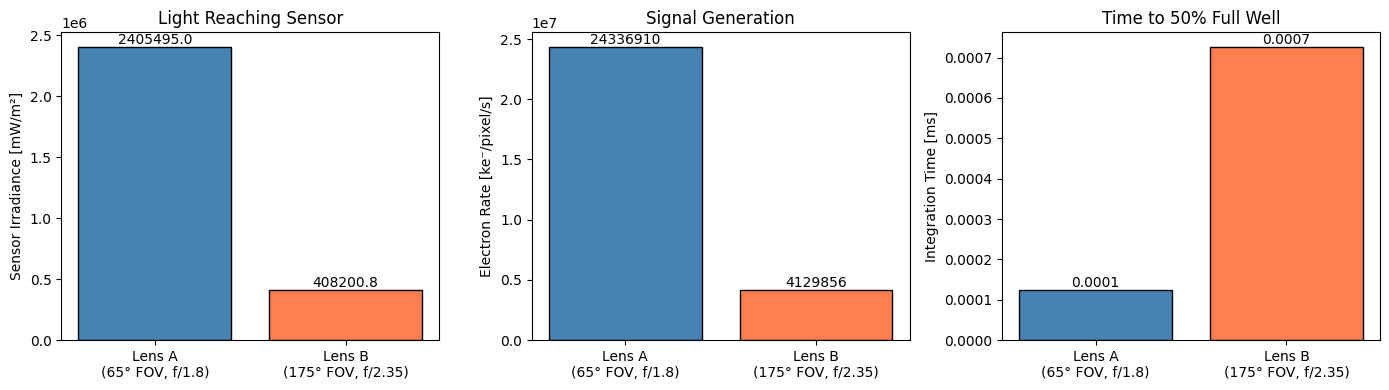


Lens A collects 5.9x more light per pixel than Lens B


In [27]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

labels = ['Lens A\n(65° FOV, f/1.8)', 'Lens B\n(175° FOV, f/2.35)']
colors = ['steelblue', 'coral']

# Plot 1: Sensor Irradiance
ax1 = axes[0]
values1 = [lens_A['E_sensor']*1000, lens_B['E_sensor']*1000]
bars1 = ax1.bar(labels, values1, color=colors, edgecolor='black')
ax1.set_ylabel('Sensor Irradiance [mW/m²]')
ax1.set_title('Light Reaching Sensor')
ax1.bar_label(bars1, fmt='%.1f')

# Plot 2: Electron Generation Rate
ax2 = axes[1]
values2 = [lens_A['electron_rate']/1000, lens_B['electron_rate']/1000]
bars2 = ax2.bar(labels, values2, color=colors, edgecolor='black')
ax2.set_ylabel('Electron Rate [ke⁻/pixel/s]')
ax2.set_title('Signal Generation')
ax2.bar_label(bars2, fmt='%.0f')

# Plot 3: Integration Time
ax3 = axes[2]
values3 = [lens_A['t_int_50']*1000, lens_B['t_int_50']*1000]
bars3 = ax3.bar(labels, values3, color=colors, edgecolor='black')
ax3.set_ylabel('Integration Time [ms]')
ax3.set_title('Time to 50% Full Well')
ax3.bar_label(bars3, fmt='%.4f')

plt.tight_layout()
plt.savefig('comparison_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nLens A collects {lens_A['E_sensor']/lens_B['E_sensor']:.1f}x more light per pixel than Lens B")

## Appendix: Skin Reflectance Data



| Fate of incident energy |Fitzpatrick I-II |Fitzpatrick III|
| :---------------------- |:-----------------:|:---------------:|
| Surface reflection | 4-7% | 4-7%| 
| Diffuse backscatter | 25-35% | 20-30% |

## 8. Sensitivity Analysis: Varying Scene Irradiance

How does the integration time change as the scene gets brighter or dimmer?

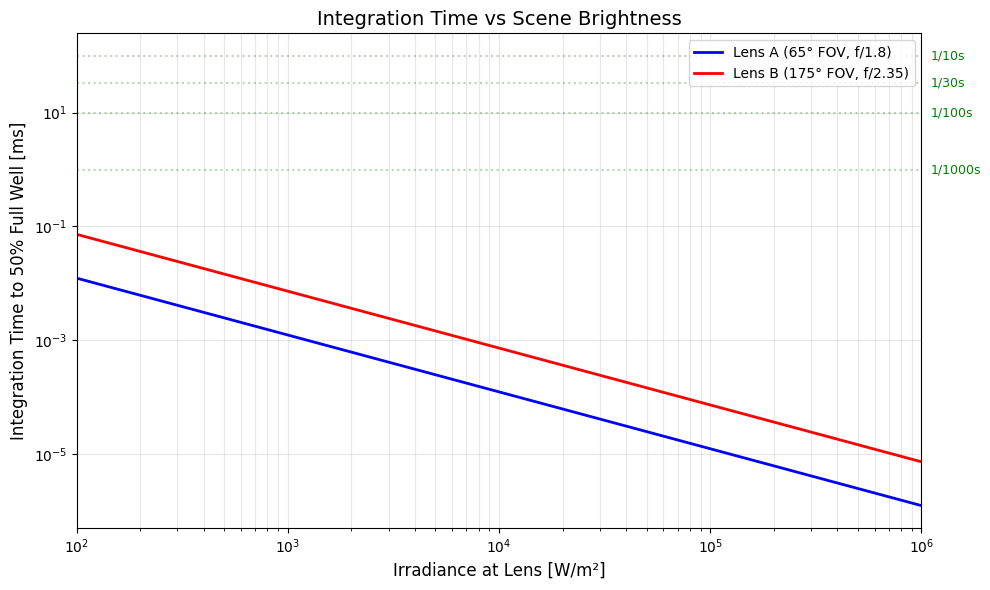

In [28]:
# Range of scene irradiances from 0.001 to 10 W/m²
E_lens_range = np.logspace(2, 6, 100)


def full_signal_chain(E_lens, sin2_alpha, f_number, transmission, 
                      E_photon, pixel_area, qe, target_electrons):
    """Calculate integration time from lens irradiance to target signal."""
    # Radiance
    L = E_lens / (np.pi * sin2_alpha)
    # Sensor irradiance
    E_sensor = (np.pi * L * transmission) / (4 * f_number**2)
    # Photon flux per pixel
    photon_flux = (E_sensor / E_photon) * pixel_area
    # Electron rate
    electron_rate = photon_flux * qe
    # Integration time
    t_int = target_electrons / electron_rate
    return t_int

# Calculate for both lenses
t_int_A = full_signal_chain(E_lens_range, lens_A['sin_squared_alpha'], lens_A['f_number'],
                            lens_transmission, E_photon, pixel_area, quantum_efficiency, target_50pct)
t_int_B = full_signal_chain(E_lens_range, lens_B['sin_squared_alpha'], lens_B['f_number'],
                            lens_transmission, E_photon, pixel_area, quantum_efficiency, target_50pct)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(E_lens_range, t_int_A * 1000, 'b-', linewidth=2, label='Lens A (65° FOV, f/1.8)')
ax.loglog(E_lens_range, t_int_B * 1000, 'r-', linewidth=2, label='Lens B (175° FOV, f/2.35)')

# Mark our example point
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5)
ax.plot(0.1, lens_A['t_int_50']*1000, 'bo', markersize=10)
ax.plot(0.1, lens_B['t_int_50']*1000, 'ro', markersize=10)

# Reference lines for common exposure times
exposure_refs = {'1/1000s': 1, '1/100s': 10, '1/30s': 33, '1/10s': 100}
for label, t_ms in exposure_refs.items():
    ax.axhline(y=t_ms, color='green', linestyle=':', alpha=0.3)
    ax.text(E_lens_range[-1]*1.1, t_ms, label, va='center', fontsize=9, color='green')

ax.set_xlabel('Irradiance at Lens [W/m²]', fontsize=12)
ax.set_ylabel('Integration Time to 50% Full Well [ms]', fontsize=12)
ax.set_title('Integration Time vs Scene Brightness', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, which='both', alpha=0.3)
ax.set_xlim(E_lens_range[0], E_lens_range[-1])

plt.tight_layout()
plt.savefig('sensitivity_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Interactive Calculator

Modify the parameters below to explore different scenarios.

In [ ]:
def ir_exposure_calculator(
    # Scene parameters
    E_lens_Wm2=10000,          # Irradiance at lens [W/m²]
    wavelength_nm=850,        # Wavelength [nm]
    
    # Lens parameters
    fov_deg=65,               # Field of view [degrees]
    f_number=1.8,             # F-number
    transmission=0.9,         # Lens transmission
    
    # Sensor parameters
    pixel_pitch_um=2.6,       # Pixel pitch [µm]
    qe=0.35,                  # Quantum efficiency
    full_well=6000            # Full well capacity [electrons]
):
    """
    Calculate exposure parameters for an IR camera system.
    
    Returns a dictionary with all intermediate and final results.
    """
    # Constants
    h = 6.626e-34
    c = 3.0e8
    
    # Derived values
    wavelength_m = wavelength_nm * 1e-9
    E_photon = (h * c) / wavelength_m
    pixel_area = (pixel_pitch_um * 1e-6) ** 2
    half_fov_rad = np.radians(fov_deg / 2)
    sin2_alpha = np.sin(half_fov_rad) ** 2
    
    # Signal chain
    radiance = E_lens_Wm2 / (np.pi * sin2_alpha)
    E_sensor = (np.pi * radiance * transmission) / (4 * f_number**2)
    photon_flux = (E_sensor / E_photon) * pixel_area
    electron_rate = photon_flux * qe
    t_int_50 = (full_well * 0.5) / electron_rate
    t_int_100 = full_well / electron_rate
    
    results = {
        'E_photon_J': E_photon,
        'E_photon_eV': E_photon / 1.602e-19,
        'radiance_Wm2sr': radiance,
        'E_sensor_Wm2': E_sensor,
        'photon_flux_per_pixel_per_s': photon_flux,
        'electron_rate_per_pixel_per_s': electron_rate,
        't_int_50pct_ms': t_int_50 * 1000,
        't_int_100pct_ms': t_int_100 * 1000,
        'equivalent_shutter_50pct': f"1/{1/t_int_50:.0f} s"
    }
    
    return results

# Example usage
print("=== Custom Calculation ===")
print("\nModify the parameters in the function call below:\n")

results = ir_exposure_calculator(
    E_lens_Wm2=0.1,
    wavelength_nm=850,
    fov_deg=65,
    f_number=1.8,
    pixel_pitch_um=2.6,
    qe=0.35
)

for key, value in results.items():
    if isinstance(value, float):
        if value < 0.01 or value > 10000:
            print(f"{key}: {value:.3e}")
        else:
            print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

=== Custom Calculation ===

Modify the parameters in the function call below:

E_photon_J: 2.339e-19
E_photon_eV: 1.4598
radiance_Wm2sr: 0.1103
E_sensor_Wm2: 0.0241
photon_flux_per_pixel_per_s: 6.953e+05
electron_rate_per_pixel_per_s: 2.434e+05
t_int_50pct_ms: 12.3270
t_int_100pct_ms: 24.6539
equivalent_shutter_50pct: 1/81 s


## 10. Diaphragm and Aperture Calculations

If we place a diaphragm (iris) in front of the lens to reduce light throughput, how large must the opening be?

### Key Relationship: Light Scales with Area, Not Diameter

To block a fraction $k$ of the light, we need:

$$A_{new} = (1-k) \cdot A_{original}$$

Since $A = \frac{\pi D^2}{4}$:

$$D_{new} = D_{original} \cdot \sqrt{1-k}$$

For blocking **half** the light ($k = 0.5$):

$$D_{new} = \frac{D_{original}}{\sqrt{2}} \approx 0.707 \times D_{original}$$

In [15]:
def calculate_diaphragm(D_original, light_fraction_blocked):
    """
    Calculate diaphragm diameter needed to block a fraction of light.
    
    Parameters:
    -----------
    D_original : float
        Original aperture diameter [any units]
    light_fraction_blocked : float
        Fraction of light to block (0 to 1). E.g., 0.5 = block half.
    
    Returns:
    --------
    D_new : float
        Required diaphragm diameter [same units as input]
    """
    light_fraction_passed = 1 - light_fraction_blocked
    D_new = D_original * np.sqrt(light_fraction_passed)
    return D_new


def calculate_new_f_number(focal_length, D_new):
    """
    Calculate the effective f-number with a reduced aperture.
    
    Parameters:
    -----------
    focal_length : float
        Lens focal length [any units]
    D_new : float
        New aperture diameter [same units as focal_length]
    
    Returns:
    --------
    N_new : float
        New f-number
    """
    return focal_length / D_new


# Calculate for both lenses - blocking 50% of light
light_blocked = 0.5

print(f"=== Diaphragm to Block {light_blocked*100:.0f}% of Light ===")
print(f"\nDiameter scaling factor: 1/√2 = {1/np.sqrt(2):.4f}")
print("\n" + "-" * 60)

for lens in [lens_A, lens_B]:
    D_original = lens['entrance_pupil_mm']
    D_new = calculate_diaphragm(D_original, light_blocked)
    N_new = calculate_new_f_number(lens['focal_length_mm'], D_new)
    
    # Store in lens dict for later use
    lens['D_half_light'] = D_new
    lens['N_half_light'] = N_new
    
    print(f"\n{lens['name']}:")
    print(f"  Original entrance pupil:    {D_original:.2f} mm (f/{lens['f_number']})")
    print(f"  Diaphragm for 50% light:    {D_new:.2f} mm (f/{N_new:.1f})")
    print(f"  F-number increase:          {N_new/lens['f_number']:.3f}x = √2")

=== Diaphragm to Block 50% of Light ===

Diameter scaling factor: 1/√2 = 0.7071

------------------------------------------------------------

Lens A (Standard):
  Original entrance pupil:    2.00 mm (f/1.8)
  Diaphragm for 50% light:    1.41 mm (f/2.5)
  F-number increase:          1.414x = √2

Lens B (Fisheye):
  Original entrance pupil:    0.51 mm (f/2.35)
  Diaphragm for 50% light:    0.36 mm (f/3.3)
  F-number increase:          1.414x = √2


### The F-Stop Connection

This is exactly where the $\sqrt{2}$ progression in f-stops comes from!

Each "stop" is a factor of $\sqrt{2}$ in the f-number:

$$N_{new} = \frac{f}{D_{new}} = \frac{f}{D/\sqrt{2}} = \sqrt{2} \cdot N_{original}$$

The standard f-stop sequence is: f/1, f/1.4, f/2, f/2.8, f/4, f/5.6, f/8, f/11, f/16, f/22...

Each step is $\times \sqrt{2} \approx 1.414$, which **halves the light**.

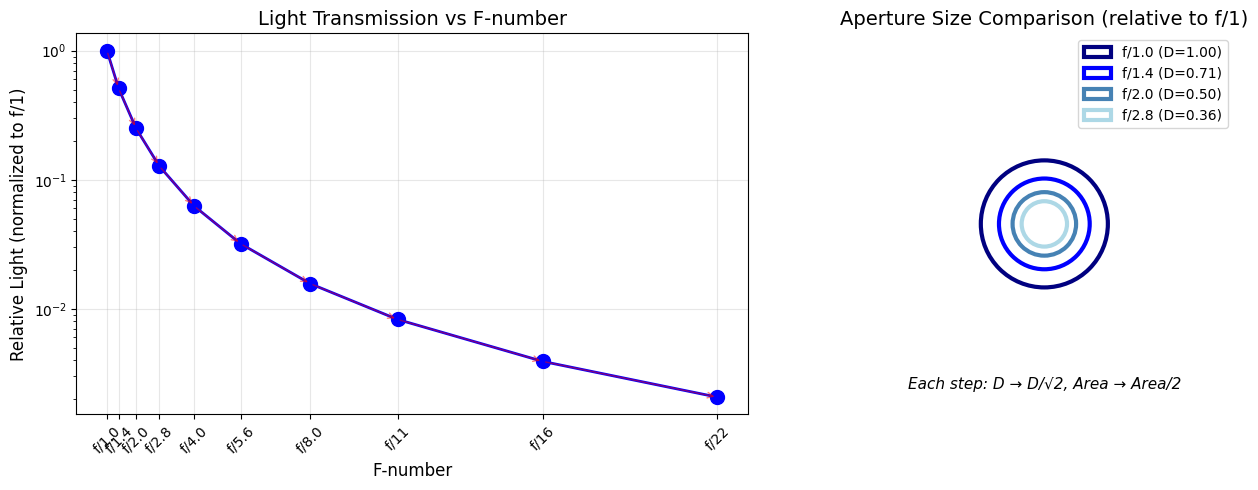

In [16]:
# Visualize the f-stop sequence and corresponding aperture areas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard f-stop sequence
f_stops = [1.0, 1.4, 2.0, 2.8, 4.0, 5.6, 8.0, 11, 16, 22]
relative_light = [1 / (f**2) for f in f_stops]  # Relative to f/1
relative_light_normalized = [r / relative_light[0] for r in relative_light]

# Plot 1: F-number vs relative light (log scale)
ax1 = axes[0]
ax1.semilogy(f_stops, relative_light_normalized, 'bo-', markersize=10, linewidth=2)
ax1.set_xlabel('F-number', fontsize=12)
ax1.set_ylabel('Relative Light (normalized to f/1)', fontsize=12)
ax1.set_title('Light Transmission vs F-number', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(f_stops)
ax1.set_xticklabels([f'f/{f}' for f in f_stops], rotation=45)

# Add annotations for halving
for i in range(len(f_stops)-1):
    ax1.annotate('', xy=(f_stops[i+1], relative_light_normalized[i+1]),
                xytext=(f_stops[i], relative_light_normalized[i]),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.5))

# Plot 2: Visual representation of aperture sizes
ax2 = axes[1]
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.set_title('Aperture Size Comparison (relative to f/1)', fontsize=14)
ax2.axis('off')

# Draw apertures for f/1, f/1.4, f/2, f/2.8
demo_f_stops = [1.0, 1.4, 2.0, 2.8]
colors = ['navy', 'blue', 'steelblue', 'lightblue']

for f, color in zip(demo_f_stops, colors):
    diameter = 1.0 / f  # Relative diameter
    circle = plt.Circle((0, 0), diameter/2, fill=False, 
                        edgecolor=color, linewidth=3, 
                        label=f'f/{f} (D={diameter:.2f})')
    ax2.add_patch(circle)

ax2.legend(loc='upper right', fontsize=10)

# Add text showing the √2 relationship
ax2.text(0, -1.3, 'Each step: D → D/√2, Area → Area/2', 
         ha='center', fontsize=11, style='italic')

plt.tight_layout()
plt.savefig('f_stop_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Interactive: Calculate diaphragm for any light reduction
print("=== Diaphragm Calculator ===")
print("\nFor Lens A (2.00 mm entrance pupil):")
print("-" * 45)
print(f"{'Light Blocked':<15} {'Diameter':<12} {'F-number':<12} {'Stops'}")
print("-" * 45)

D_A = lens_A['entrance_pupil_mm']
f_A = lens_A['focal_length_mm']
N_A = lens_A['f_number']

for fraction in [0.25, 0.50, 0.75, 0.875, 0.9375]:
    D_new = calculate_diaphragm(D_A, fraction)
    N_new = calculate_new_f_number(f_A, D_new)
    stops = np.log2((N_new / N_A) ** 2)  # Number of stops difference
    print(f"{fraction*100:>6.1f}%{'':<8} {D_new:>6.2f} mm{'':<4} f/{N_new:<6.1f}    +{stops:.0f} stop(s)")

print("\n" + "=" * 45)
print("Note: Each stop = 2× light reduction = √2× f-number")

=== Diaphragm Calculator ===

For Lens A (2.00 mm entrance pupil):
---------------------------------------------
Light Blocked   Diameter     F-number     Stops
---------------------------------------------
  25.0%           1.73 mm     f/2.1       +0 stop(s)
  50.0%           1.41 mm     f/2.5       +1 stop(s)
  75.0%           1.00 mm     f/3.6       +2 stop(s)
  87.5%           0.71 mm     f/5.1       +3 stop(s)
  93.8%           0.50 mm     f/7.2       +4 stop(s)

Note: Each stop = 2× light reduction = √2× f-number


In [18]:
# Show impact on integration time
print("=== Impact on Integration Time ===")
print("\nWith diaphragm blocking 50% of light:\n")

for lens in [lens_A, lens_B]:
    # Original integration time
    t_original = lens['t_int_50'] * 1000  # in ms
    
    # With 50% light blocked, need 2× integration time
    t_new = t_original * 2
    
    print(f"{lens['name']}:")
    print(f"  Original:     {t_original:.1f} ms (f/{lens['f_number']})")
    print(f"  With 50% blocked: {t_new:.1f} ms (f/{lens['N_half_light']:.1f})")
    print(f"  Shutter speed: 1/{1000/t_original:.0f}s → 1/{1000/t_new:.0f}s\n")

=== Impact on Integration Time ===

With diaphragm blocking 50% of light:

Lens A (Standard):
  Original:     12.3 ms (f/1.8)
  With 50% blocked: 24.7 ms (f/2.5)
  Shutter speed: 1/81s → 1/41s

Lens B (Fisheye):
  Original:     72.6 ms (f/2.35)
  With 50% blocked: 145.3 ms (f/3.3)
  Shutter speed: 1/14s → 1/7s



### Summary: Diaphragm Sizing

| Lens | Original Pupil | F-number | Diaphragm (50% light) | New F-number |
|------|----------------|----------|----------------------|---------------|
| A (65° FOV) | 2.00 mm | f/1.8 | **1.41 mm** | f/2.5 |
| B (175° FOV) | 0.51 mm | f/2.35 | **0.36 mm** | f/3.3 |

The $\sqrt{2}$ factor connecting diameter to light throughput is fundamental to:
- The f-stop scale in photography
- Aperture design in optical systems
- Understanding the tradeoff between light gathering and depth of field

## 11. Key Equations Reference

### Photon Energy
$$E_{photon} = \frac{hc}{\lambda}$$

### Extended Source Radiometry
$$E_{lens} = \pi \cdot L \cdot \sin^2(\alpha)$$

### Camera Equation
$$E_{sensor} = \frac{\pi \cdot L \cdot \tau}{4 \cdot N^2}$$

### Combined Form (lens irradiance to sensor irradiance)
$$E_{sensor} = \frac{E_{lens} \cdot \tau}{4 \cdot N^2 \cdot \sin^2(\alpha)}$$

### Signal Chain
$$\Phi_{pixel} = \frac{E_{sensor}}{E_{photon}} \times A_{pixel}$$

$$\dot{n}_e = QE \times \Phi_{pixel}$$

$$t_{int} = \frac{n_{target}}{\dot{n}_e}$$

### Diaphragm/Aperture
$$D_{new} = D_{original} \cdot \sqrt{1-k}$$

where $k$ is the fraction of light blocked.

For half light ($k=0.5$):
$$D_{half} = \frac{D_{original}}{\sqrt{2}}$$

### F-number relationship
$$N = \frac{f}{D}$$

$$\text{Light} \propto \frac{1}{N^2}$$